# DenseNet bird classification

## Table of Contents
* [Introduction](#introduction)
* [Dataset](#dataset)
* [Imports](#imports)
* [Train/Test/Validation split](#train/test/validation-split)
    * [Dataset merger](#dataset-merger)
    * [Dataset redistribution](#dataset-redistribution)
* [Modeling](#modeling)
    * [Choosing a Model](#choosing-a-model)
    * [Callbacks](#callbacks)
    * [Training](#training)
* [Loading weights](#loading-weights)
* [Evaluation](#evaluation)
    * [Predictions](#predictions)
    * [Metrics](#metrics)
* [Conclusion](#conclusion)


<a id="introduction"></a>
## Introduction

Jupyter Notebook explores the application of DenseNet, a powerful convolutional neural network architecture, for multilabel image classification of bird species across 525 unique classes. The core objective is to assess DenseNet's capability in handling datasets with a high degree of variability, showcasing its applicability in classifying bird species with varying appearances, behaviors, and habitats. The dataset comprises 525 bird classes, each with numerous images.

The aim is to leverage DenseNet for its superior performance on large datasets, thanks to its dense connectivity pattern that promotes feature reuse and parameter efficiency.

The methodology involves preprocessing the images, designing the DenseNet model, training it on the dataset, and assessing its performance.

<a id="dataset"></a>
## Dataset

The dataset used for this project can be found on Kaggle: [BIRDS 525 SPECIES-IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)

I selected this one because I wanted to test out the performance of Deep Learning models against a large number of classes (bird species)

Data cleaning is mostly done, and the author has already split dataset into train/test/validation subsets

<a id="imports"></a>
## Imports

For starters, we need to import the required packages:

In [1]:
import os
import cv2
import numpy as np
from datetime import datetime

# Modeling
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-26 19:47:57.825714: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 19:47:58.665633: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 19:48:00.754847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 19:48:04.556418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Settings:

In [2]:
# Define paths
TRAIN_DIR = 'dataset/train'
VALIDATION_DIR = 'dataset/valid'
TEST_DIR = 'dataset/test'
CHECKPOINTS_DIR = "checkpoints"
LOG_DIR = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")  # Logs directory
MODEL_FILEPATH = "checkpoints/model-024-0.526.keras"  # Filepath of the model to load (Not used with weights approach)
MODEL_WEIGHTS = "checkpoints/weights/model.weights.h5"

# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
USE_WEIGHTS = True  # Set to true in case of retraining model from weights otherwise false

and auxiliary functions:

In [3]:
def preprocessing(image, label):
    """
    Applies preprocessing to an image and returns the processed image along with its label.
    
    return:Processed image and original label.
    """
    image = preprocess_input(image)
    return image, label


def compile_model(start_epoch=0):
    """
    Loads DenseNet121 model, adds custom layers, perform model compile depending on wheather or not you want to use
    weights
    
    return: Compiled model, initial epoch number
    """
    # Load the DenseNet model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Final model
    model = Model(inputs=base_model.input, outputs=predictions)

    if USE_WEIGHTS is True and os.path.exists(MODEL_WEIGHTS):
        print(f"Weights loading from : {MODEL_WEIGHTS}")
        model.load_weights(MODEL_WEIGHTS)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model, start_epoch

def get_class_names(test_dataset):
    """
    Extracts class names from a test dataset.

    return: Class names extracted from the test dataset.
    """
    class_names = test_dataset.class_names
    return class_names


def load_and_preprocess_image(image_path):
    """
    Loads an image from disk, resizes it, expands dimensions, and preprocesses it.

    return: Preprocessed image ready for model input.
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)  
    img = np.expand_dims(img, axis=0) 
    img = preprocess_input(img)
    return img


def predict_image(image_path, test_dataset):
    """
    Predicts the class of an image using a precompiled model.
    Prints the predicted class name, class index, and prediction accuracy.

    return: None
    """
    # Reconstruct model architecture
    model, start_epoch = compile_model()

    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)

    # Make prediction
    pred = model.predict(image)
    predicted_class = int(np.argmax(pred, axis=1))
    accuracy = np.max(pred)
    class_names = get_class_names(test_dataset)

    # Print the prediction result
    print(f"Predicted Class: {predicted_class}, Class Name: {class_names[predicted_class]}, Accuracy: {accuracy}")

def find_max_fp_fn_class(multiclass_cm, class_names):
    """
    Find the class with the maximum sum of false positives and false negatives.

    return: uple containing the index of the class with the maximum sum of FP+FN,
    and the confusion matrix for that class.
    """
    max_fp_fn_sum = 0
    max_fp_fn_class = None

    for i, cm in enumerate(multiclass_cm):
        fp = cm[0][1]
        fn = cm[1][0]
        total_fp_fn = fp + fn
        
        if total_fp_fn > max_fp_fn_sum:
            max_fp_fn_sum = total_fp_fn
            max_fp_fn_class = i

    result = (max_fp_fn_class,)
    result += (class_names[max_fp_fn_class],)
    
    return result

<a id="train/test/validation-split"></a>
## Train/Test/Validation split

As the author mentions, the subsets are preselected: "NOTE: The test and validation images in the data set were hand selected to be the "best" images so your model will probably get the highest accuracy score using those data sets versus creating your own test and validation sets. However the latter case is more accurate in terms of model performance on unseen images." 

For my purposes, I would like to have a different split ratio; hence, I was using the following scripts to tailor it for my needs.

Additionally, because I don't want it to be executed every time (one is enough to rearrange datasets), I left the code in docstring.

<a id="dataset-merger"></a>
### Dataset-merger

This script collects data from train / test / valid directories and puts them into a single directory while keeping subdirectory names with labels. It should be used with the dataset_redistribution script to get the data split ratio you want.

In [ ]:
"""
import os
import shutil

source_dirs = ['dataset/train', 'dataset/test', 'dataset/valid']
target_dir = 'converted_dataset'

subdirs = set()

for source_dir in source_dirs:
    for root, dirs, files in os.walk(source_dir):
        for directory in dirs:
            subdirs.add(directory)

for subdir in subdirs:
    # Create the target subdirectory
    target_subdir_path = os.path.join(target_dir, subdir)
    os.makedirs(target_subdir_path, exist_ok=True)

    # Initialize a counter for renaming images
    image_counter = 1

    for source_dir in source_dirs:
        source_subdir_path = os.path.join(source_dir, subdir)
        if os.path.exists(source_subdir_path):
            for file in os.listdir(source_subdir_path):
                if file.endswith('.jpg'):
                    # Construct the full file path
                    source_file_path = os.path.join(source_subdir_path, file)
                    # Construct the new file name
                    new_file_name = f"{image_counter}.jpg"
                    target_file_path = os.path.join(target_subdir_path, new_file_name)
                    # Copy and rename the file
                    shutil.copy(source_file_path, target_file_path)
                    # Increment the counter
                    image_counter += 1

"""

<a id="dataset-redistribution"></a>
### Dataset-redistribution

After using dataset_merger, we get all the data combined in converted_dataset. This script accesses the said dataset and splits it into a specified ratio

In [ ]:
"""
import splitfolders

# Specify the input folder where your original directories are located
input_folder = "converted_dataset"

# Specify the output folder where you want the split datasets to be saved
output = "dataset"

# Use the split_folders.ratio function to split the dataset
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8, 0.1, 0.1))

"""

<a id="modeling"></a>
## Modeling

<a id="choosing-a-model"></a>
### Choosing a Model

While in the process of selecting a model initially there were couple considerations among others: EfficientNet, Xception and DenseNet. 

This [paper](https://www.mdpi.com/2079-9292/12/14/3132) was a major help in model selection.

Takaways:

* Mobilenet and Resnet were struggling with more difficult dataset
* While on recommended image size for easy dataset, Mobilenet and Resnet achieved remarkable accuracy. In these ideal scenarios, Densenet followed by Xception performed in very good 98% range
* On harder dataset, Densenet followed by Xception outperformed Mobilenet and Resnet
* On smaller image sizes (75x75 which is smaller than models recommended), Densenet and Xception also outperformed the rest

As I wanted to optimize for performance on difficult datasets, ultimately DenseNet was selected

<a id="callbacks"></a>
### Callbacks

* <b>TensorBoard</b> - Provides us with access to Tensorboard, very useful tool, particularly to analyze loss curves during or after training. With that, I could have information of model performance on train and validation sets.
* <b>ModelCheckpoint</b> - Works as a safety measure. Each epoch, if the model was improved in terms of a selected metric (validation loss in my case), it saved a model at that point. Model could then be restored in case of some emergency
* <b>EarlyStopping</b> - To save time and computational power, each time there were no model improvements for prolonged time this callback stops training process
* <b>ReduceLROnPlateau</b> - Similarly to previous one, if the model was not improving for prolonged time, this callback reduced learning rate. In theory, this allows to train the model some more before it stagnates.

  To prevent training being stopped before learning rate reduced, the ReduceLROnPlateau callback has smaller patience setting (meaning it would trigger before Early stopping)

<a id="training"></a>
### Training

As the training process is already done by me, and we are going to be loading its results directly as weights, I decided to include code for training I used as a docstring to don't disturb flow of notebook:

Data loading and preprocessing can be seen here:

In [ ]:
"""
# Load and preprocess the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Load and preprocess the datasets
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Load and preprocess the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

# Apply preprocessing to the training dataset
train_dataset = train_dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
# Apply preprocessing to the validation dataset
validation_dataset = validation_dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
# Apply preprocessing to the test dataset
test_dataset = test_dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
"""

And training, here:

In [ ]:
"""
# Define callbacks
tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

checkpoint_callback = ModelCheckpoint(filepath=f"{CHECKPOINTS_DIR}/model-{{epoch:03d}}-{{val_loss:.3f}}.keras",
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      mode='auto')

early_stopping_callback = EarlyStopping(monitor="val_loss",
                                        patience=5,
                                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6
                              )

# Compile model
model, start_epoch = compile_model()

# Train the model with TensorBoard callback
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback, reduce_lr],
                    initial_epoch=start_epoch)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# Save the model in TensorFlow SavedModel format
model.save('trained_models/data_fixed.keras')
"""

Assuming training logs are in logs directory, we could just access them in tensorboard to explore training process already done by me.

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir logs

Running this as a single training process was impossible for me, because I could not afford to run this on my setup 100% of the time. This can be noted in the different color of the lines on the graph (it counted as a separate run). Each new color line corresponded to me loading the weights and starting where it left off.

Also, the moments at which learning rates were reduced are clearly visible, as well as the positive impact of that callback on overall model performance. The model kept improving for a while after each change except the last one.

Training ended due to model not improving and EarlyStopping callback triggering.

<b>In case of tensorflow not loading, here are noteworthy graphs in form of image:</b>

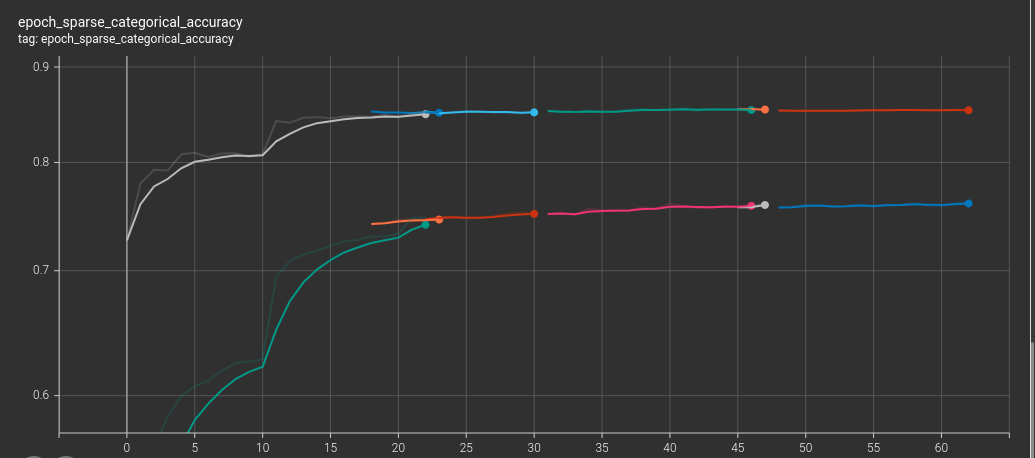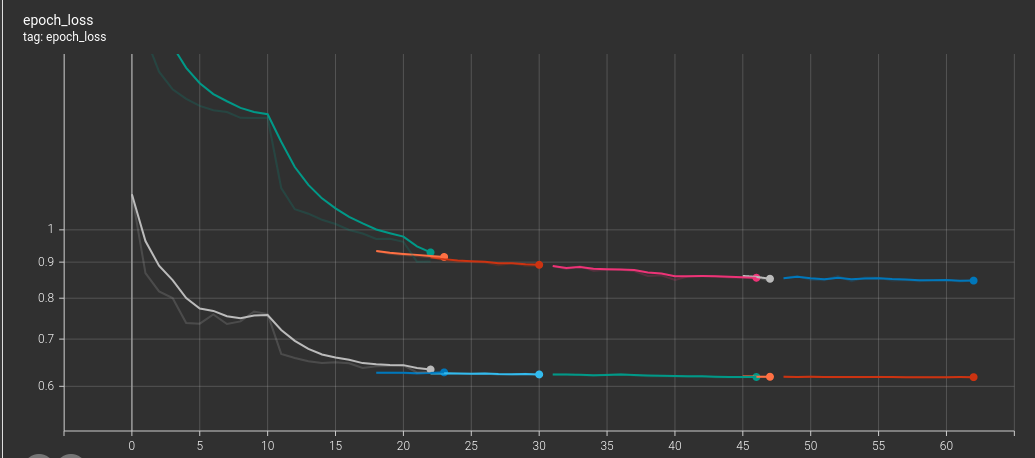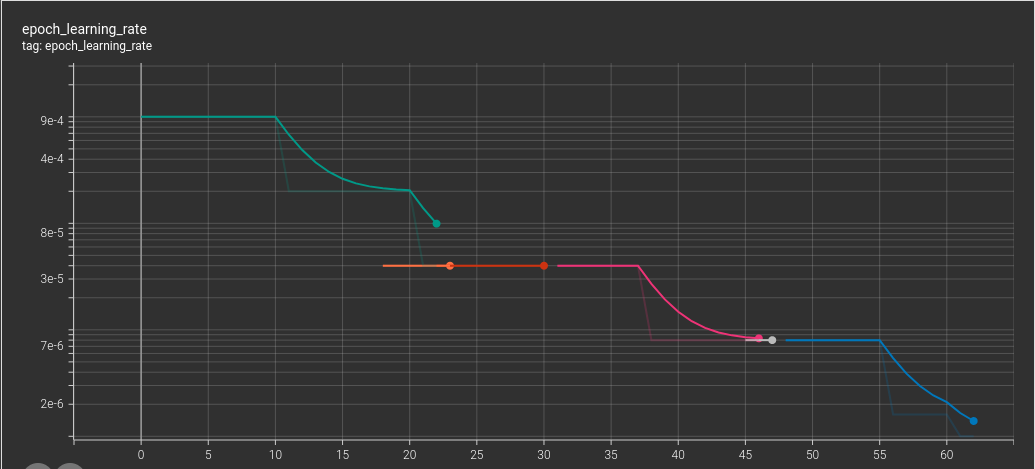

<a id="loading-weights"></a>
## Loading weights

For the purpose of this presentation, let's load the weights from the end of the training process, and work from there. What's important is the  USE_WEIGHTS setting, which should be set to True otherwise it will not load the weights, and we don't want to start training from a scratch.

<b>We load a test dateset as the other ones were used for training.</b>

In [4]:
# Load and preprocess the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

Found 9388 files belonging to 526 classes.


2024-06-26 19:55:19.496206: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 19:55:19.672880: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


This next block will become useful for predictions, but <b>it is important to get it done before we apply mapping to dataset</b>

In [5]:
# Initialize an empty list to hold the labels
labels_list = []

# Iterate over the dataset to collect labels
for images, labels in test_dataset:
    labels_list.extend(labels.numpy())

# Get the class names from the test dataset
class_names = test_dataset.class_names

2024-06-26 19:55:47.630874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


After that, we proceed as planned with loading weights

In [6]:
# Apply preprocessing to the test dataset
test_dataset = test_dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

# Reconstruct model architecture
model, start_epoch = compile_model()

Weights loading from : checkpoints/weights/model.weights.h5


If everything went well, now we have our trained model saved into model and ready for further operations

<a id="evaluation"></a>
### Evaluation

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

2024-06-26 19:56:23.194579: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-06-26 19:56:23.513360: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53231616 exceeds 10% of free system memory.
2024-06-26 19:56:23.565920: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-06-26 19:56:23.609403: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-06-26 19:56:23.613172: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


587/587 ━━━━━━━━━━━━━━━━━━━━ 512s 863ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.8424
Test accuracy: 0.8567320108413696, Test loss: 0.6019572615623474


In general for dataset like this I'm content with 85% accuracy. If I were to improve this model further, I would inspect the data for classes that were underperforming. Some other CNN models or different layers could be tested, but in general it's more cost-effective to improve data rather than model.

<a id="predictions"></a>
### Predictions

Let's see how the model performs on unseen data, following script will show us detection for each image provided in test set:

In [8]:
pred = model.predict(test_dataset)
pred = np.argmax(pred, axis=1)


positive_count = 0
negative_count = 0

for i, item in enumerate(pred):
    print("Detected: ", item, "-", class_names[item], "True: ", labels_list[i], "-", class_names[labels_list[i]])
    if item == labels_list[i]:
        positive_count += 1
    else:
        negative_count += 1

print(f"Precision: {positive_count/(negative_count+positive_count)}")

587/587 ━━━━━━━━━━━━━━━━━━━━ 509s 863ms/step
Detected:  259 - GREATER PEWEE True:  0 - ABBOTTS BABBLER
Detected:  38 - ASHY THRUSHBIRD True:  0 - ABBOTTS BABBLER
Detected:  435 - RUFOUS TREPE True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  130 - CAPE ROCK THRUSH True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  347 - MERLIN True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  196 - DUSKY ROBIN True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER True:  0 - ABBOTTS BABBLER
Detected:  0 - ABBOTTS BABBLER Tr

As we can see, it becomes rather tedious to go entry by entry for these predictions. Nevertheless, it is worth to skim through the results to confirm there are no glaring issues with our predictions. We will get more reader friendly data with scikit-learn metrics module next section.

<a id="metrics"></a>
### Metrics

Let's start with <b>confusion matrix</b>. It will allow us to compare performance of each class. Additionally, I will focus on the ones that are underperforming, as there is more room for improvement there. With custom function, we can see the confusion matrix of a class that has most false positives + false negatives.

In [9]:
# Compute the multilabel confusion matrix 
mcm = multilabel_confusion_matrix(labels_list, pred)

# Get confussion metric with the worst false positive/negative scores
result = find_max_fp_fn_class(mcm, class_names=class_names)
print(f"Class with maximum FP+FN: {(result)}")
print(mcm[result[0]])

Class with maximum FP+FN: (43, 'AUCKLAND SHAQ')
[[9356   11]
 [   9   12]]


Similarly, we can see metric for each class using <b>classification report</b>. That allows us to pinpoint areas where the model is underperforming and potentially verify/enhance data in that area.

In [10]:
# Generate the classification report
report = classification_report(labels_list, pred, target_names=class_names)
print(report)

                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.75      0.67      0.71        18
                ABBOTTS BOOBY       0.67      0.63      0.65        19
   ABYSSINIAN GROUND HORNBILL       0.95      0.90      0.92        20
        AFRICAN CROWNED CRANE       1.00      0.87      0.93        15
       AFRICAN EMERALD CUCKOO       0.93      0.82      0.88        17
            AFRICAN FIREFINCH       0.74      0.88      0.80        16
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00        17
        AFRICAN PIED HORNBILL       0.91      0.95      0.93        21
          AFRICAN PYGMY GOOSE       0.90      0.95      0.93        20
                    ALBATROSS       0.69      0.73      0.71        15
               ALBERTS TOWHEE       0.64      0.78      0.70        18
         ALEXANDRINE PARAKEET       0.95      1.00      0.97        18
                ALPINE CHOUGH       0.81      0.89      0.85        19
     

/home/peter/PycharmProjects/DenseNet_bird_classification/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/peter/PycharmProjects/DenseNet_bird_classification/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/peter/PycharmProjects/DenseNet_bird_classification/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

<a id="conclusion"></a>
## Conclusion

In this project, I tackled the challenge of classifying birds into 525 different species using DenseNet and managed to achieve an 85% accuracy rate after over 60 training cycles. I took care to prepare our data properly and utilized callbacks to monitor the training process closely. TensorBoard was my go-to tool for keeping an eye on everything, and we adjusted the train/test/validation splits to ensure the model stayed sharp. Overall, DenseNet proved it's quite capable of handling large, complex datasets.

The is definitely room for improvement, particularly for certain underperforming classes, by enhancing their images. Ultimately I decided to stay with provided dataset potentially this can be better compared with other models performance.